---
author: Zeel B Patel
badges: true
categories: ML, GP
description: Multi-class GP classification with different strategies
title: Multi-class classification with Gaussian Processes
date: '2023-07-04'
toc: true
---

In [9]:
import GPy
import numpy as np

from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessClassifier, kernels

import matplotlib.pyplot as plt

## Common functions

In [2]:
def get_kernel(ard):
    return GPy.kern.RBF(2, ARD=ard)

def create_and_fit_model(model_class, X, y, ard, **kwargs):
    model = model_class(X, y, get_kernel(ard), **kwargs)
    model.optimize()
    return model

def plot_predictions(predict_fn, ax, fig, discrete=False):
    grid1 = np.linspace(X.min(axis=0)[0]-1, X.max(axis=0)[0]+1, 50)
    grid2 = np.linspace(X.min(axis=0)[1]-1, X.max(axis=0)[1]+1, 50)
    Grid1, Grid2 = np.meshgrid(grid1, grid2)
    X_test = np.vstack([Grid1.ravel(), Grid2.ravel()]).T
    
    y_pred = predict_fn(X_test)
    if discrete:
        y_pred = y_pred.round()
    y_pred = y_pred.reshape(Grid1.shape)
    
    ax.scatter(X[:, 0], X[:, 1], c=y)
    mappable = ax.contourf(Grid1, Grid2, y_pred, alpha=0.5, levels=10)
    fig.colorbar(mappable, ax=ax)

## Generate Synthetic Data

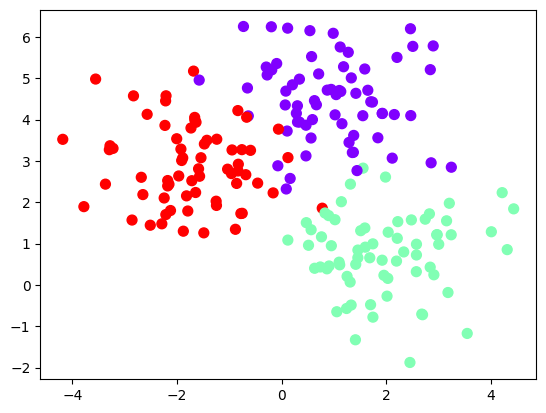

In [3]:
X, y = make_blobs(n_samples=200, centers=3, random_state=0)
# X, y = make_moons(n_samples=200, noise=0.1, random_state=0)
y = y.reshape(-1, 1)
encoder = OneHotEncoder(sparse=False)
encoder.fit(y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

## Train-test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
y_train_one_hot = encoder.transform(y_train)
y_test_one_hot = encoder.transform(y_test)

## Treat it as a regression problem

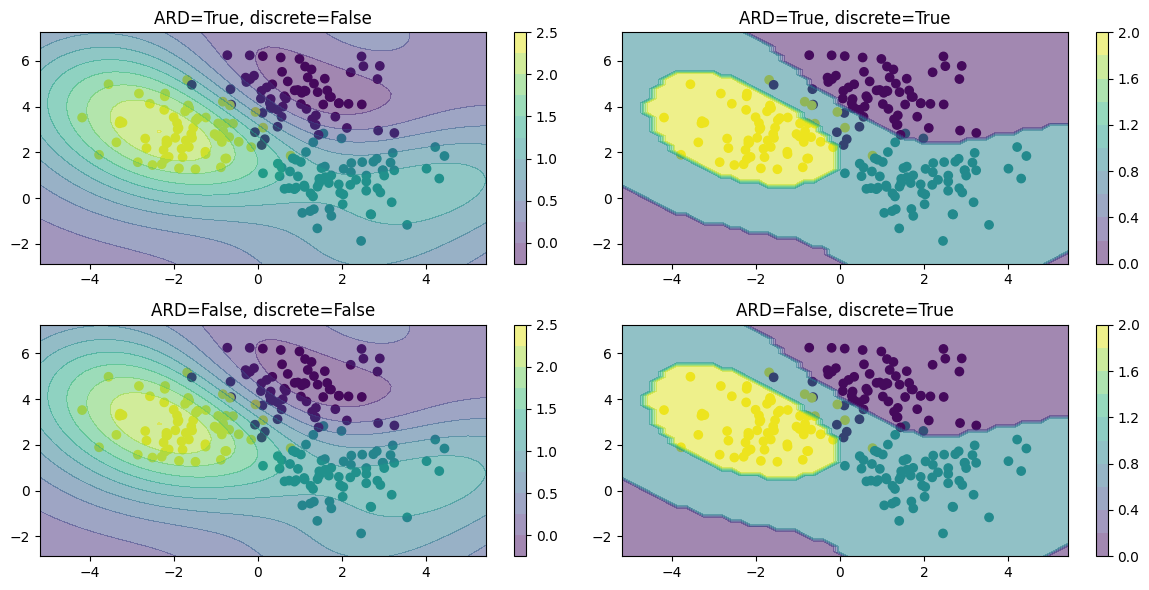

In [5]:
ard_model = create_and_fit_model(GPy.models.GPRegression, X_train, y_train, ard=True)
non_ard_model = create_and_fit_model(GPy.models.GPRegression, X_train, y_train, ard=False)

fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax = ax.ravel()
i = 0
for model in [ard_model, non_ard_model]:
    for discrete in [False, True]:
        predict_fn = lambda x: model.predict(x)[0]
        plot_predictions(predict_fn, ax[i], fig, discrete=discrete)
        ax[i].set_title(f"ARD={model.kern.ARD}, discrete={discrete}")
        i += 1
        
plt.tight_layout()

## Treat it as a multi-output regression problem

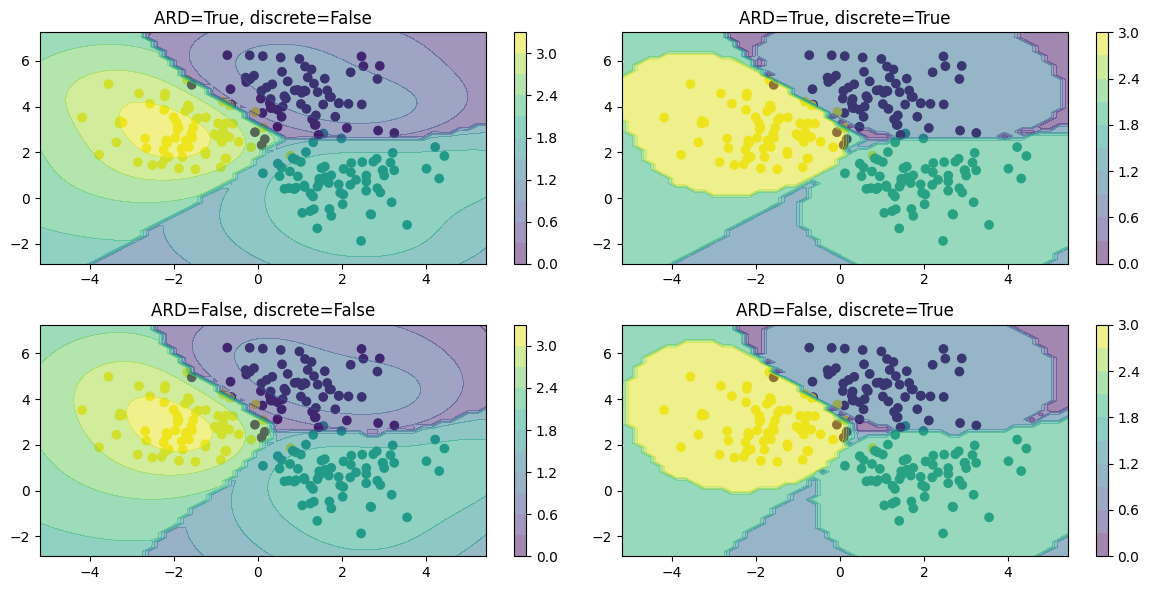

In [6]:
ard_model = create_and_fit_model(GPy.models.GPRegression, X_train, y_train_one_hot, ard=True)
non_ard_model = create_and_fit_model(GPy.models.GPRegression, X_train, y_train_one_hot, ard=False)

fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax = ax.ravel()
i = 0
for model in [ard_model, non_ard_model]:
    for discrete in [False, True]:
        predict_fn = lambda x: np.max(model.predict(x)[0], axis=1) + np.argmax(model.predict(x)[0], axis=1)
        plot_predictions(predict_fn, ax[i], fig, discrete=discrete)
        ax[i].set_title(f"ARD={model.kern.ARD}, discrete={discrete}")
        i += 1
        
plt.tight_layout()

## Treat it as a One v/s Rest classification problem

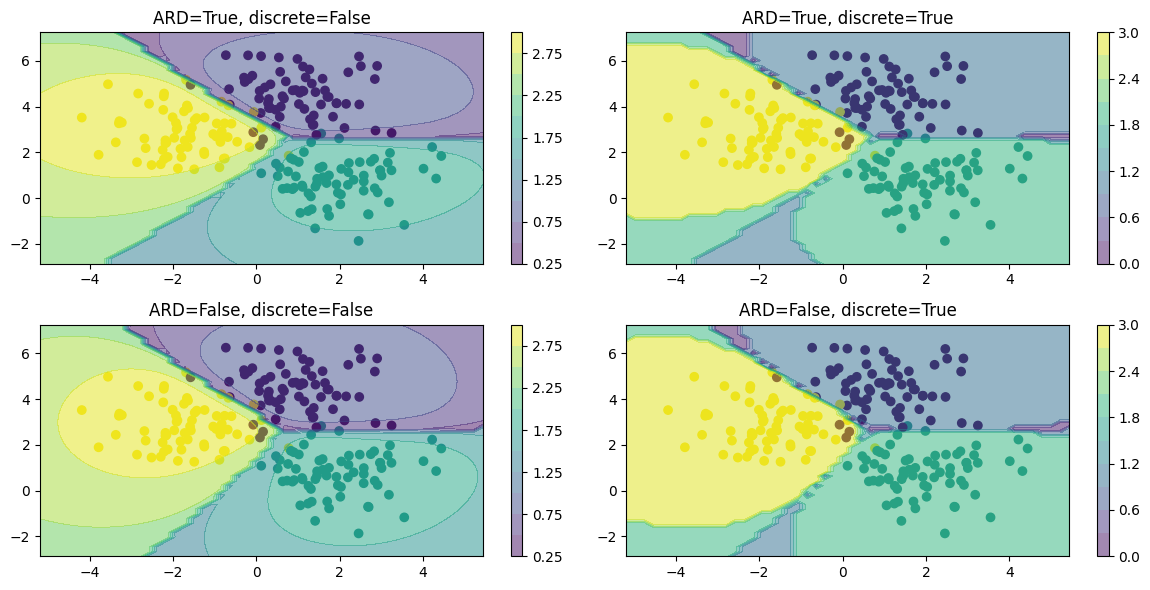

In [25]:
ard_kernel = kernels.ConstantKernel() * kernels.RBF(length_scale=[1.0, 1.0])
non_ard_kernel = kernels.ConstantKernel() * kernels.RBF(length_scale=1.0)
ard_model = GaussianProcessClassifier(kernel=ard_kernel)
non_ard_model = GaussianProcessClassifier(kernel=non_ard_kernel)
ard_model.fit(X_train, y_train.ravel())
non_ard_model.fit(X_train, y_train.ravel())

fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax = ax.ravel()
i = 0
for model in [ard_model, non_ard_model]:
    for discrete in [False, True]:
        predict_fn = lambda x: np.max(model.predict_proba(x), axis=1) + np.argmax(model.predict_proba(x), axis=1)
        plot_predictions(predict_fn, ax[i], fig, discrete=discrete)
        ax[i].set_title(f"ARD={bool(len(np.atleast_1d(model.kernel.k2.length_scale))-1)}, discrete={discrete}")
        i += 1

plt.tight_layout()